We are going to solve the following problem:

    dy1/dx = 10 * (y2 - y1)

    dy2/dx = y1 * (15 - y3) - y2

    dy3/dx = y1 * y2 - 8/3 * y3

In [5]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


2024-02-18 13:01:48.117267: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


In [6]:
# load dataset
def gen_traindata():
    data = np.load("./Lorenz.npz")
    return data["t"], data["y"]
observe_t, ob_y = gen_traindata()

In [40]:
# code adapted from https://github.com/maziarraissi/PINNs/blob/master/main/continuous_time_identification%20(Navier-Stokes)/NavierStokes.py
class PhysicsInformedNN:
    def __init__(self, t, y, layers):

        # prepare the data for further use in the model
        self.X = t.reshape(-1, 1) # X is matrix n_inputs x n_samples. In this case time is the only input
        self.t = t.reshape(-1, 1) # X is matrix n_inputs x n_samples. In this case time is the only input

        # indentify the min and max of the input data for normalizing before feeding to the model
        self.lb = self.X.min(0)
        self.ub = self.X.max(0)
        
        # save the output data
        self.y1 = y[:, 0:1]
        self.y2 = y[:, 1:2]
        self.y3 = y[:, 2:3]
        
        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Initialize parameters
        self.C_1 = tf.Variable([10.0], dtype=tf.float32)
        self.C_2 = tf.Variable([10.0], dtype=tf.float32)
        self.C_3 = tf.Variable([10.0], dtype=tf.float32)

        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        #inputs
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])   
        #outputs
        self.y1_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y1.shape[1]])
        self.y2_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y2.shape[1]])
        self.y3_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y3.shape[1]])
        
        # compute the terms of the ODE to be considered in the loss function
        self.y1_pred, self.y2_pred, self.y3_pred, self.y1_t_pred, self.y2_t_pred, self.y3_t_pred = self.net_ode(self.t_tf)

        self.loss = tf.reduce_sum(tf.square(self.y1 - self.y1_pred)) + \
                    tf.reduce_sum(tf.square(self.y2 - self.y2_pred)) + \
                    tf.reduce_sum(tf.square(self.y3 - self.y3_pred)) + \
                    tf.reduce_sum(tf.square(self.y1_t_pred)) + \
                    tf.reduce_sum(tf.square(self.y2_t_pred)) + \
                    tf.reduce_sum(tf.square(self.y3_t_pred))
        
        self.loss_data = tf.reduce_sum(tf.square(self.y1 - self.y1_pred)) + \
                    tf.reduce_sum(tf.square(self.y2 - self.y2_pred)) + \
                    tf.reduce_sum(tf.square(self.y3 - self.y3_pred))
        
        self.loss_ode = tf.reduce_sum(tf.square(self.y1_t_pred)) + \
                    tf.reduce_sum(tf.square(self.y2_t_pred)) + \
                    tf.reduce_sum(tf.square(self.y3_t_pred))

        
        """
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})  
        """
        # replaced code with the following line as proposed here: https://github.com/tensorflow/tensorflow/issues/48167
        self.optimizer = dde.optimizers.tensorflow_compat_v1.scipy_optimizer.ScipyOptimizerInterface(self.loss, 
                                                            method = 'L-BFGS-B', 
                                                            options = {'maxiter': 50000,
                                                                       'maxfun': 50000,
                                                                       'maxcor': 50,
                                                                       'maxls': 50,
                                                                       'ftol' : 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)


    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)


    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    # use case specific: to be modified
    def net_ode(self, t):
        C_1 = self.C_1
        C_2 = self.C_2
        C_3 = self.C_3
        
        y = self.neural_net(tf.concat([t], 1), self.weights, self.biases)
        y1 = y[:,0:1]
        y2 = y[:,1:2]
        y3 = y[:,2:3]
        
        y1_t = tf.gradients(y1, t)[0]
        y2_t = tf.gradients(y2, t)[0]
        y3_t = tf.gradients(y3, t)[0]
    

        f_y1 = y1_t - C_1* (y2 - y1)
        f_y2 = y2_t - y1 * (C_2 - y3) + y2
        f_y3 = y3_t - y1 * y2 + C_3 * y3
        
        return y1, y2, y3, f_y1, f_y2, f_y3
    
    # use case specific: to be modified
    def callback(self, loss, loss_data, loss_ode, C_1, C_2, C_3):
        print('Loss: %.3e, Loss Data: %.3e, Loss ODE: %.3e, C1: %.5f, C2: %.5f, C3: %.5f' % (loss, loss_data, loss_ode, C_1, C_2, C_3))


    # use case specific: to be modified
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t,
                   self.y1_tf: self.y1, self.y2_tf: self.y2, self.y3_tf: self.y3}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_data = self.sess.run(self.loss_data, tf_dict)
                loss_ode = self.sess.run(self.loss_ode, tf_dict)
                C_1_value = self.sess.run(self.C_1)
                C_2_value = self.sess.run(self.C_2)
                C_3_value = self.sess.run(self.C_3)
        
                                
                print('It: %d, Loss: %.3e, loss_data: %.3e, loss_ode: %.3e, C1: %.5f, C2: %.5f, C3: %.5f, Time: %.2f' % 
                      (it, loss_value, loss_data, loss_ode, C_1_value, C_2_value, C_3_value, elapsed))
                start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_data, self.loss_ode, self.C_1, self.C_2, self.C_3],
                                loss_callback = self.callback)
        

    # use case specific: to be modified        
    def predict(self, t_star):
        
        tf_dict = {self.t_tf: t_star}
        
        y1_star = self.sess.run(self.y1_pred, tf_dict)
        y2_star = self.sess.run(self.y2_pred, tf_dict)
        y3_star = self.sess.run(self.y3_pred, tf_dict)
        
        return y1_star, y2_star, y3_star

In [41]:
# Training
layers = [1, 50, 50, 50, 3]
model = PhysicsInformedNN(observe_t, ob_y, layers)
model.train(20000)

Device mapping: no known devices.


(None, 1)
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device

2024-02-18 13:56:49.411731: I tensorflow/core/common_runtime/placer.cc:125] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.411785: I tensorflow/core/common_runtime/placer.cc:125] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.411791: I tensorflow/core/common_runtime/placer.cc:125] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.411795: I tensorflow/core/common_runtime/placer.cc:125] Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.411803: I tensorflow/core/common_runtime/placer.cc:125] Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.411806: I tensorflow/core/common_runtime/placer.cc:125] Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.411809: I tensorflow/core/common_runtime/placer.cc:125] Variable_1:

gradients_38/gradients_37/Tanh_23_grad/TanhGrad_grad/mul_2: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_37/Tanh_23_grad/TanhGrad_grad/TanhGrad: (TanhGrad): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_35/Tanh_23_grad/TanhGrad_grad/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_35/Tanh_23_grad/TanhGrad_grad/mul_1: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_35/Tanh_23_grad/TanhGrad_grad/mul_2: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_35/Tanh_23_grad/TanhGrad_grad/TanhGrad: (TanhGrad): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_36/Tanh_23_grad/TanhGrad_grad/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_36/Tanh_23_grad/TanhGrad_grad/mul_1: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_38/gradients_36/Tanh_23_grad/TanhGrad_grad/mul_2: (Mul): /job:localhost/replica:0/

ost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.604892: I tensorflow/core/common_runtime/placer.cc:125] gradients_38/sub_79_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.604896: I tensorflow/core/common_runtime/placer.cc:125] gradients_38/sub_79_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.604900: I tensorflow/core/common_runtime/placer.cc:125] gradients_38/sub_79_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.604903: I tensorflow/core/common_runtime/placer.cc:125] gradients_38/sub_79_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.604907: I tensorflow/core/common_runtime/placer.cc:125] gradients_38/sub_79_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.604916: I tensorflow/core/common_runtime/placer.cc:125] gradients_38/gradients_35/mul_35_grad/Mul_1_

Reshape_1537: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1538: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1539: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1540: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1541: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1542: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1543: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1544: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1545: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1546: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1547: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1548: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1549: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1550: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_1551: (Resha

-02-18 13:56:49.824432: I tensorflow/core/common_runtime/placer.cc:125] gradients_48/gradients_46/truediv_9_grad/RealDiv_grad/RealDiv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.824438: I tensorflow/core/common_runtime/placer.cc:125] gradients_48/gradients_46/truediv_9_grad/RealDiv_grad/Neg: (Neg): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.824446: I tensorflow/core/common_runtime/placer.cc:125] gradients_48/gradients_46/truediv_9_grad/RealDiv_grad/RealDiv_1: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.824452: I tensorflow/core/common_runtime/placer.cc:125] gradients_48/gradients_46/truediv_9_grad/RealDiv_grad/RealDiv_2: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.824459: I tensorflow/core/common_runtime/placer.cc:125] gradients_48/gradients_46/truediv_9_grad/RealDiv_grad/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:49.824465: I tensorflow/

Assign_895: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2548: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_896: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2549: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_897: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2550: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_898: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2551: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_899: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2552: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_900: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2553: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_901: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_2554: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_902: (Assign): /job:localhost/repl

I tensorflow/core/common_runtime/placer.cc:125] gradients_70/truediv_14_grad/RealDiv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.219139: I tensorflow/core/common_runtime/placer.cc:125] gradients_70/truediv_14_grad/Neg: (Neg): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.219146: I tensorflow/core/common_runtime/placer.cc:125] gradients_70/truediv_14_grad/RealDiv_1: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.219152: I tensorflow/core/common_runtime/placer.cc:125] gradients_70/truediv_14_grad/RealDiv_2: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.219158: I tensorflow/core/common_runtime/placer.cc:125] gradients_70/truediv_14_grad/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.219164: I tensorflow/core/common_runtime/placer.cc:125] gradients_70/truediv_14_grad/Shape: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.2191

Reshape_3493: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1247: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3494: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1248: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3495: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1249: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3496: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1250: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3497: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1251: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3498: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1252: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3499: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
Assign_1253: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3500: (Reshape): /job:loca

2024-02-18 13:56:50.434987: I tensorflow/core/common_runtime/placer.cc:125] gradients_9/gradients_7/truediv_1_grad/RealDiv_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.435015: I tensorflow/core/common_runtime/placer.cc:125] gradients_9/gradients_7/truediv_1_grad/RealDiv_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.435024: I tensorflow/core/common_runtime/placer.cc:125] gradients_9/sub_17_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.435031: I tensorflow/core/common_runtime/placer.cc:125] gradients_9/sub_18_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.435039: I tensorflow/core/common_runtime/placer.cc:125] gradients_9/gradients_5/truediv_1_grad/RealDiv_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.435045: I tensorflow/core/common_runtime/placer.cc:125] gradients_9/gra

gradients_13/Add_20_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_13/Add_20_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_9: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_10: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_11/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_11/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_12: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_13: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_14: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_15: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_16: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_17: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_18: (Const): /job:localhost/replica:0/task:0/device:CPU:0
zeros_like_19: (Const): /job:l

2024-02-18 13:56:50.682486: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_326: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.682505: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_327/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.682527: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_327/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.682538: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_328: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.682546: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_329/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.682553: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_329/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.682559: I tensorflow/core/common_runtime/placer.cc:125] zero

gradients_46/Add_99_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/Add_99_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/sub_91_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/sub_91_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/truediv_9_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/truediv_9_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/mul_45_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/mul_45_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/sub_90_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_46/sub_90_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_47/grad_ys_0/Const: (Const): /job:lo

ost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885848: I tensorflow/core/common_runtime/placer.cc:125] Reshape_2322/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885860: I tensorflow/core/common_runtime/placer.cc:125] Reshape_2323/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885867: I tensorflow/core/common_runtime/placer.cc:125] Reshape_2324/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885873: I tensorflow/core/common_runtime/placer.cc:125] Reshape_2325/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885880: I tensorflow/core/common_runtime/placer.cc:125] Reshape_2326/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885887: I tensorflow/core/common_runtime/placer.cc:125] Reshape_2327/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:50.885894: I tensorflow/core/common_runtime/place

Placeholder_903: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_904: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_905: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_906: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_907: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_908: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_909: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_910: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_911: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_912: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_913: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_914: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
Placeholder_915: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0

host/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169587: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_983: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169593: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_984: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169598: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_985: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169605: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_986: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169611: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_987: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169618: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_988: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2024-02-18 13:56:51.169624: I tensorflow/core/common_runtime/placer.cc:125] zeros_like_98

Reshape_3774/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3775/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3776/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3777/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3778/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3779/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3780/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3781/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3782/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3783/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3784/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3785/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3786/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape_3787/shape: (Const): /job:loca

/tmp/ipykernel_93303/1254134830.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('It: %d, Loss: %.3e, loss_data: %.3e, loss_ode: %.3e, C1: %.5f, C2: %.5f, C3: %.5f, Time: %.2f' %


It: 0, Loss: 8.298e+03, loss_data: 8.263e+03, loss_ode: 3.515e+01, C1: 9.99900, C2: 9.99900, C3: 9.99900, Time: 0.28
It: 1000, Loss: 7.575e+03, loss_data: 7.387e+03, loss_ode: 1.884e+02, C1: 8.86006, C2: 8.84331, C3: 8.70837, Time: 1.52
It: 2000, Loss: 5.414e+03, loss_data: 5.111e+03, loss_ode: 3.024e+02, C1: 7.88504, C2: 7.35715, C3: 7.35734, Time: 1.30
It: 3000, Loss: 1.359e+03, loss_data: 1.330e+03, loss_ode: 2.985e+01, C1: 6.61528, C2: 7.19813, C3: 6.64298, Time: 1.34
It: 4000, Loss: 9.842e+02, loss_data: 9.648e+02, loss_ode: 1.931e+01, C1: 6.78194, C2: 8.27301, C3: 6.06556, Time: 1.32
It: 5000, Loss: 6.836e+02, loss_data: 6.668e+02, loss_ode: 1.678e+01, C1: 6.97815, C2: 9.18343, C3: 5.44789, Time: 1.34
It: 6000, Loss: 1.198e+03, loss_data: 1.147e+03, loss_ode: 5.037e+01, C1: 6.37637, C2: 10.16345, C3: 5.07316, Time: 1.34
It: 7000, Loss: 5.274e+02, loss_data: 5.190e+02, loss_ode: 8.378e+00, C1: 5.78933, C2: 10.95157, C3: 4.65150, Time: 1.31
It: 8000, Loss: 3.161e+02, loss_data: 3.1

KeyboardInterrupt: 

In [25]:
[y1, y2, y3] = model.predict(observe_t)

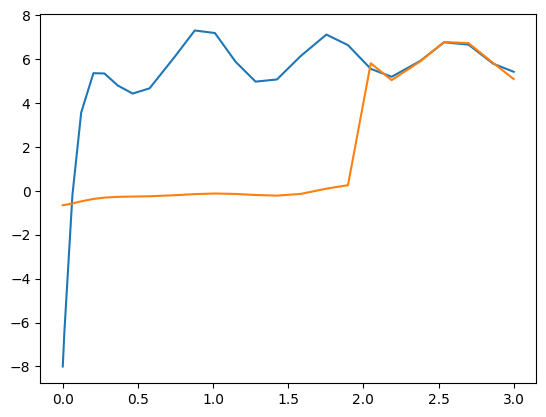

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)
axs[0].plot(observe_t, ob_y[:, 0], label='True y1')
axs[0].plot(observe_t, y1, label='Predicted y1')

axs[1].plot(observe_t, ob_y[:, 1], label='True y1')
axs[1].plot(observe_t, y2, label='Predicted y1')

axs[2].plot(observe_t, ob_y[:, 2], label='True y1')
axs[2].plot(observe_t, y3, label='Predicted y1')